<a href="https://colab.research.google.com/github/AdvaitJay/Healthcaredata-Analysis/blob/main/ReadmissionRateEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Readmission Prediction: Cleaning, Visualization, Modeling & Evaluation Metrics

In [19]:

import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

train_df.head()


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,69,Male,Heart Disease,1,2,1,Home Health Care,0
1,32,Female,COPD,2,13,2,Rehabilitation Facility,0
2,89,Male,Diabetes,1,7,1,Home,0
3,78,Male,COPD,9,2,2,Skilled Nursing Facility,0
4,38,Male,Diabetes,6,4,4,Rehabilitation Facility,0


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                5000 non-null   int64 
 1   gender             5000 non-null   object
 2   primary_diagnosis  5000 non-null   object
 3   num_procedures     5000 non-null   int64 
 4   days_in_hospital   5000 non-null   int64 
 5   comorbidity_score  5000 non-null   int64 
 6   discharge_to       5000 non-null   object
 7   readmitted         5000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 312.6+ KB


## Data Cleaning

In [21]:
train_df.isnull().sum()

,0
age,0
gender,0
primary_diagnosis,0
num_procedures,0
days_in_hospital,0
comorbidity_score,0
discharge_to,0
readmitted,0


In [22]:

# Fill missing values
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    else:
        train_df[col].fillna(train_df[col].median(), inplace=True)

train_df.isnull().sum()


/tmp/ipython-input-2164017201.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
/tmp/ipython-input-2164017201.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

,0
age,0
gender,0
primary_diagnosis,0
num_procedures,0
days_in_hospital,0
comorbidity_score,0
discharge_to,0
readmitted,0


## Data Visualization

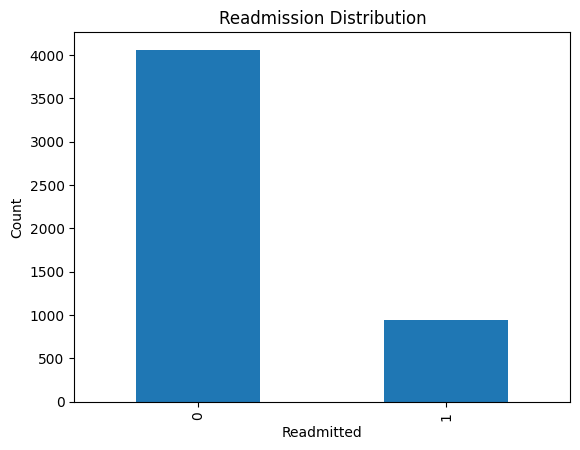

In [23]:

train_df['readmitted'].value_counts().plot(kind='bar')
plt.title('Readmission Distribution')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()


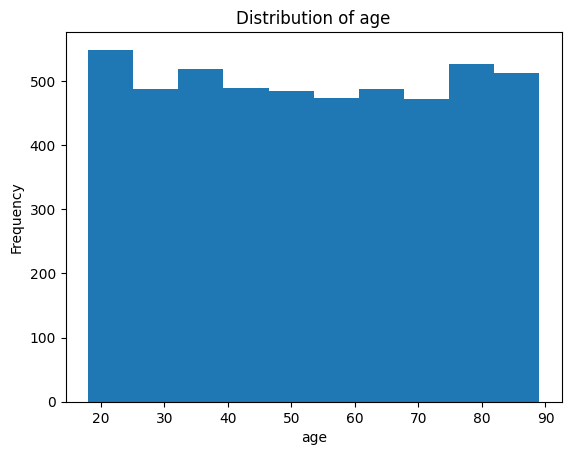

In [24]:

num_cols = train_df.select_dtypes(include=['number']).columns
train_df[num_cols[0]].plot(kind='hist')
plt.title(f'Distribution of {num_cols[0]}')
plt.xlabel(num_cols[0])
plt.show()


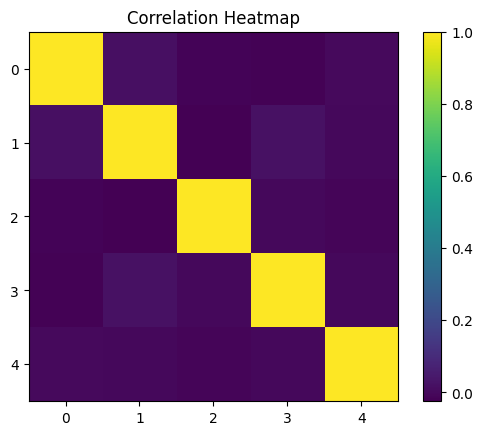

In [25]:

import numpy as np
corr = train_df.select_dtypes(include=['number']).corr()
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Heatmap')
plt.colorbar()
plt.show()


## Model Building & Evaluation Metrics

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

target = 'readmitted'
X = train_df.drop(columns=[target])
y = train_df[target]

cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(include=['number']).columns

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

model.fit(X_train, y_train)

preds = model.predict(X_valid)
probs = model.predict_proba(X_valid)[:,1]

print("Accuracy:", accuracy_score(y_valid, preds))
print(classification_report(y_valid, preds))


Accuracy: 0.805
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       812
           1       0.23      0.02      0.03       188

    accuracy                           0.81      1000
   macro avg       0.52      0.50      0.46      1000
weighted avg       0.70      0.81      0.73      1000



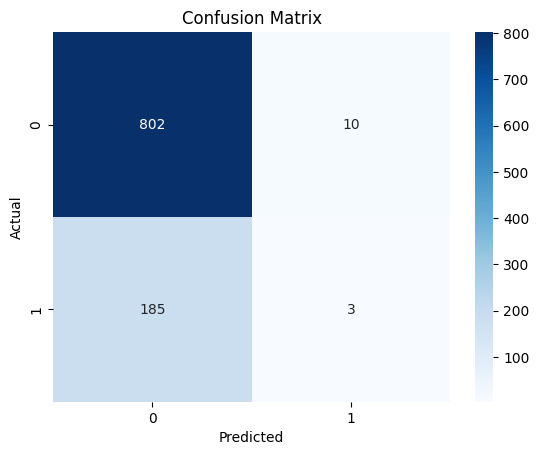

In [27]:

cm = confusion_matrix(y_valid, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


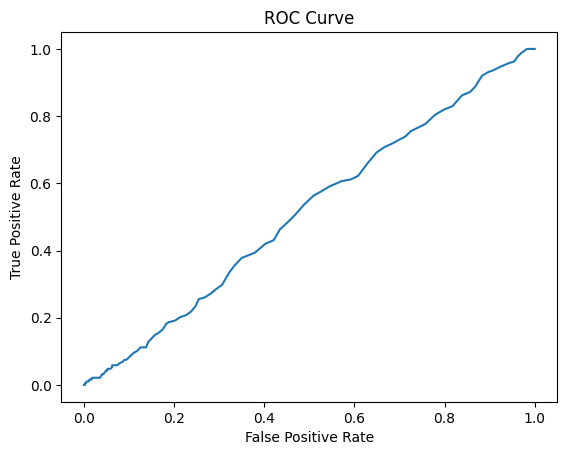

np.float64(0.5150305261502988)

In [28]:

fpr, tpr, thresh = roc_curve(y_valid, probs)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

roc_auc = roc_auc_score(y_valid, probs)
roc_auc


In [29]:

test_predictions = model.predict(test_df)
pd.DataFrame({'prediction': test_predictions}).head()


,prediction
0,0
1,0
2,0
3,0
4,0
